In [1]:
import numpy as np
import pymc3 as pm
from scipy import stats
from theano import tensor as tt

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
Nd = 5
N = 100
mu0 = stats.norm.rvs(loc=0, scale=1., size=Nd)
W = stats.norm.rvs(loc=0, scale=1, size=(Nd, Nd))
K = W*W.transpose() + np.diagflat(np.ones((Nd, 1))*Nd)
L = np.linalg.cholesky(K)
X = stats.multivariate_normal.rvs(mu0, K, size=N)

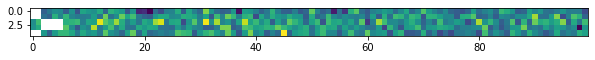

In [3]:
X_ma = np.ma.array(X)
X_ma[:2, [0, 1, 4]] = np.ma.masked
X_ma[2:6, [2, 3]] = np.ma.masked

_, ax = plt.subplots(figsize=(10, 3))
ax.imshow(X_ma.T);

In [4]:
X_nonma = X_ma.data[X_ma.mask.sum(axis=1) == 0]
maskall = X_ma.mask[X_ma.mask.sum(axis=1) > 0]
X_slice = X_ma.data[X_ma.mask.sum(axis=1) > 0]
uni_case = np.unique(maskall, axis=0)

In [5]:
maskall

array([[ True,  True, False, False,  True],
       [ True,  True, False, False,  True],
       [False, False,  True,  True, False],
       [False, False,  True,  True, False],
       [False, False,  True,  True, False],
       [False, False,  True,  True, False]])

In [6]:
for im in uni_case:
    pass
im

array([ True,  True, False, False,  True])

In [7]:
X_slice[np.sum(maskall == im, axis=1) > 0, :][:, im == False]

array([[0.83211316, 1.0748402 ],
       [4.15863449, 2.92505775]])

In [8]:
K[im == False, :][:, im == False]

array([[ 9.04092886, -0.09144359],
       [-0.09144359,  6.50482452]])

## Full data set (as comparison)

In [9]:
with pm.Model() as model0:
    mu = pm.Normal('mu', mu=0, sd=10, shape=Nd)
    sd_dist = pm.HalfCauchy.dist(beta=2.5)
    chol, corr, sigmas = pm.LKJCholeskyCov(
        'chol_cov', n=Nd, eta=1, sd_dist=sd_dist, compute_corr=True)
    corr = pm.Deterministic('corr', corr)
    
    obs = pm.MvNormal('obs', mu=mu, chol=chol, observed=X)
    trace0 = pm.sample(2000, cores=4, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [chol_cov, mu]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 20 seconds.


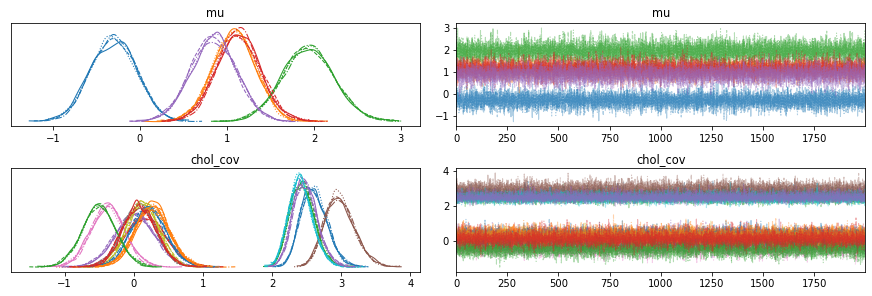

In [10]:
pm.traceplot(trace0, var_names=['mu', 'chol_cov']);

## nonmasked data set only

In [11]:
with pm.Model() as model0_:
    mu = pm.Normal('mu', mu=0, sd=10, shape=Nd)
    sd_dist = pm.HalfCauchy.dist(beta=2.5)
    chol, corr, sigmas = pm.LKJCholeskyCov(
        'chol_cov', n=Nd, eta=1, sd_dist=sd_dist, compute_corr=True)
    corr = pm.Deterministic('corr', corr)
    
    obs = pm.MvNormal('obs', mu=mu, chol=chol, observed=X_nonma)
    trace0_ = pm.sample(2000, cores=4, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [chol_cov, mu]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 21 seconds.


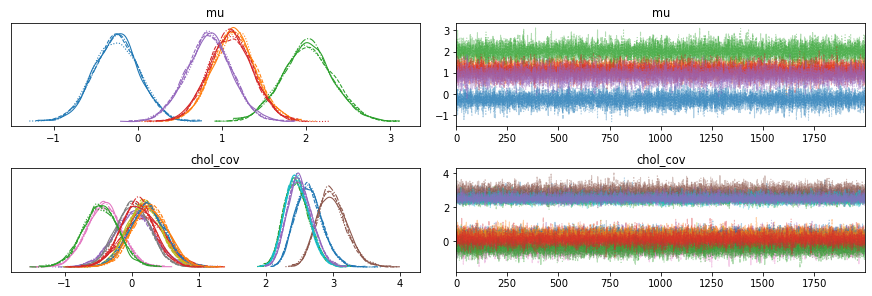

In [12]:
pm.traceplot(trace0_, var_names=['mu', 'chol_cov']);

## with masked data

In [14]:
## Full data set (as comparison)

with pm.Model() as model1_:
    mu = pm.Normal('mu', mu=0, sd=10, shape=Nd)
    sd_dist = pm.HalfCauchy.dist(beta=2.5)
    chol, corr, sigmas = pm.LKJCholeskyCov(
        'chol_cov', n=Nd, eta=1, sd_dist=sd_dist, compute_corr=True)
    cov = pm.Deterministic('cov', tt.dot(chol, chol.T))
    # non-masked data (no missing observation)
    obs = pm.MvNormal('obs', mu=mu, chol=chol, observed=X_ma)
    trace1_ = pm.sample(2000, cores=4, return_inferencedata=True)

/home/junpenglao/miniconda3/lib/python3.7/site-packages/pymc3/model.py:1668: ImputationWarning: Data in obs contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [obs_missing, chol_cov, mu]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 26 seconds.


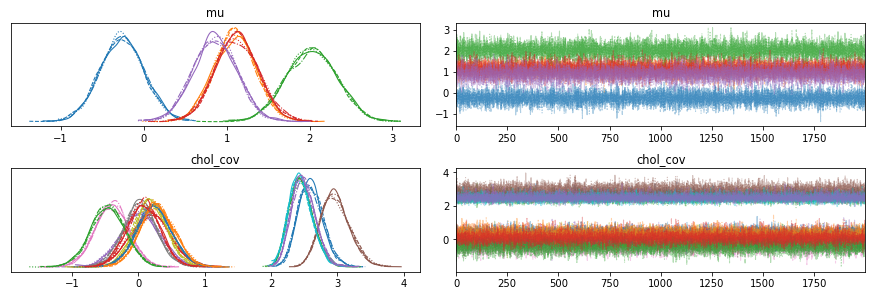

In [15]:
pm.traceplot(trace1_, var_names=['mu', 'chol_cov']);

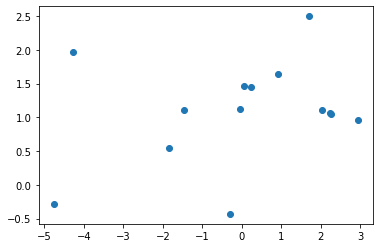

In [25]:
obs_missing = trace1_.posterior['obs_missing'].values
plt.plot(X[X_ma.mask], obs_missing.mean(axis=(0, 1)), 'o');

In [30]:
np.where(X_ma.mask)

(array([0, 0, 0, 1, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5]),
 array([0, 1, 4, 0, 1, 4, 2, 3, 2, 3, 2, 3, 2, 3]))

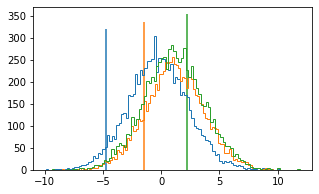

In [26]:
_, ax = plt.subplots(1, 1, figsize=(5, 3), sharex=True)

for i in range(true_val.shape[-1]):
    *_, line = ax.hist(np.ravel(obs_missing[..., i]), 100, histtype='step')
    ax.vlines(X[X_ma.mask][i], *ax.get_ylim(), color=line[0].get_edgecolor());

## with masked data

In [27]:
## Full data set (as comparison)

with pm.Model() as model1:
    mu = pm.Normal('mu', mu=0, sd=10, shape=Nd)
    sd_dist = pm.HalfCauchy.dist(beta=2.5)
    chol, corr, sigmas = pm.LKJCholeskyCov(
        'chol_cov', n=Nd, eta=1, sd_dist=sd_dist, compute_corr=True)
    cov = pm.Deterministic('cov', tt.dot(chol, chol.T))
    # non-masked data (no missing observation)
    obs = pm.MvNormal('obs', mu=mu, chol=chol, observed=X_nonma)
    # masked data. It is likely that we can optimized it further by turning it into a potential
    # (thus removing the for-loop)
    for i, im in enumerate(uni_case):
        pm.MvNormal('obs%i'%(i), 
                    mu[im == False],
                    cov[im == False, :][:, im == False],
                    observed=X_slice[np.sum(maskall == im, axis=1) > 0, :][:, im == False])
    trace1 = pm.sample(2000, cores=4, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [chol_cov, mu]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 76 seconds.


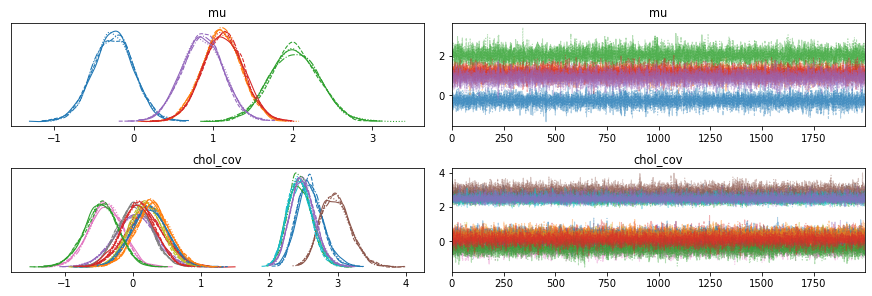

In [28]:
pm.traceplot(trace1, var_names=['mu', 'chol_cov']);

## contruct conditional and sample from it

In [29]:
def MVN_conditional(mu_post, cov_post, conditional):
    mask = conditional.mask
    mu1 = mu_post[..., mask]
    mu2 = mu_post[..., ~mask]
    a = conditional.data[~mask]
    S11 = cov_post[..., mask, :][..., mask]
    S12 = cov_post[..., mask, :][..., ~mask]
    S21 = np.einsum('...ij->...ji', S12)
    S22 = cov_post[..., ~mask, :][..., ~mask]
    S12_dot_invS22 = np.einsum('...ij,...jk->...ik', S12, np.linalg.inv(S22))
    mu_new = mu1 + np.einsum('...ij,...j->...i', S12_dot_invS22, a-mu2)
    S_new = S11 - np.einsum('...ij,...jk->...ik', S12_dot_invS22, S21)
    chol_S_new = np.linalg.cholesky(S_new)
    sample_raw = np.random.randn(*mu_new.shape)
    sample = mu_new + np.einsum('...ji,...j->...i', chol_S_new, sample_raw)
    return sample

In [31]:
conditional = X_ma[0]
mu_post = trace1.posterior['mu'].values
cov_post = trace1.posterior['cov'].values
X0_post_condi = MVN_conditional(mu_post, cov_post, conditional)

In [32]:
X0_post_condi.shape

(4, 2000, 3)

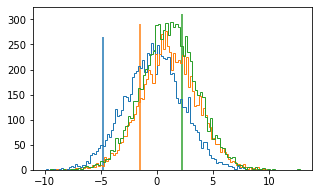

In [33]:
_, ax = plt.subplots(1, 1, figsize=(5, 3), sharex=True)
true_val = X[0][conditional.mask]
for i in range(X0_post_condi.shape[-1]):
    *_, line = ax.hist(X0_post_condi[..., i].ravel(), 100, histtype='step')
    ax.vlines(true_val[i], *ax.get_ylim(), color=line[0].get_edgecolor());